In [1]:
import pandas as pd
import numpy as np
import glob, os, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import matplotlib

matplotlib.rcParams["font.family"] = 'arial'

OUTPUT_DIR = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_variant_num"
if os.path.exists(OUTPUT_DIR) == False:
    os.system("mkdir -p " + OUTPUT_DIR)

In [2]:
def calc_vaf (df, col, location):
    # Split "depthalt" column by comma, convert to integers, and calculate division
    df[['depth', 'alt']] = df[ col ].str.split(',', expand=True).astype(int)
    df['vaf'] = df['alt'] / df['depth']

    #df = df [ df["depth"] >= 10]

    # Drop the intermediate columns if needed
    df = df.drop(['depth', 'alt'], axis=1)
    df [ "location" ] = location
    return df    

def  drawfigure_raw (ax, df, row_index, col_index, vaf_col, color ):
    import scipy.stats as kde
    
    x = np.linspace(0, 0.51, 100)
    kde_function = kde.gaussian_kde( np.array (df [ vaf_col ]) )
    y = kde_function(x) 

    ax.plot (x, y, label = col_index, linewidth = 5, color = color)
    ax.fill_between(x, y, color = color, alpha=0.3)

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_common (ax, df, row_index, col_index, vaf_col, weight ):
    import scipy.stats as kde
    
    if df.shape[0] >= 5:
        x = np.linspace(0, 0.51, 100)
        kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
        y = kde_function(x)  * weight

        ax.plot (x, y, label = col_index, linewidth = 8, color = '#4B4A53')

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_clone (ax, df, row_index, col_index, vaf_col, clone_no, weight ):
    import scipy.stats as kde
    import palettable
    
    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
    Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors

    colorlist = [i for i in Pastel_10]

    if df.shape[0] >= 2:
        x = np.linspace(0, 0.51, 100)
        kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
        y = kde_function(x) * weight

        ax.plot (x, y, label = col_index, linewidth = 3, color = colorlist[clone_no], linestyle='-.')
        ax.fill_between(x, y, color = colorlist[clone_no], alpha=0.4)

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )



def stackedbar_tissue ( fig, ax, df_count, decision_dict, colorlist, **kwargs):

    from collections import OrderedDict 

    normalized_df = df_count.div(df_count.sum(axis=0), axis=1).T * 100
    normalized_df = normalized_df.apply(lambda row: pd.Series(sorted(row, reverse = True)), axis=1)

    if kwargs ["ORDER"] == "Hard-Soft":
        df_order = pd.DataFrame.from_dict ( OrderedDict (decision_dict), orient = "index" )
        df_order.columns = ["decision"]

        normalized_df = pd.merge (normalized_df, df_order, left_index=True, right_index = True, how='left').sort_values (by = "decision").drop("decision", axis = 1)    # Hard - Soft 순서대로 sort 하기

    normalized_df.plot.bar (stacked = True, width = 0.8, ax = ax, color = colorlist, edgecolor = "gray")
    ax.set_xticklabels ( ax.get_xticklabels(), rotation = kwargs["ROTATION"], fontsize = 15, fontweight = "semibold")

    return normalized_df, df_order


def stackedbar_by_score ( fig, ax, normalized_df, colorlist, **kwargs):
    normalized_df.plot.bar (stacked = True, width = 0.8, ax = ax, color = colorlist, edgecolor = "gray", legend = False)
    ax.set_xticklabels ( ax.get_xticklabels(), rotation = kwargs["ROTATION"], fontsize = 12, fontweight = "semibold")
    ax.set_ylabel ("Proportion of variant number (%)", fontsize = 15, fontweight = "normal")



# Define a custom function to calculate standard deviation excluding zeros
def std_without_zeros(row):
    non_zero_values = [value for value in row if value != 0]
    if non_zero_values:
        return np.std(non_zero_values)
    return 0  # If all values are zero, return 0



## AG

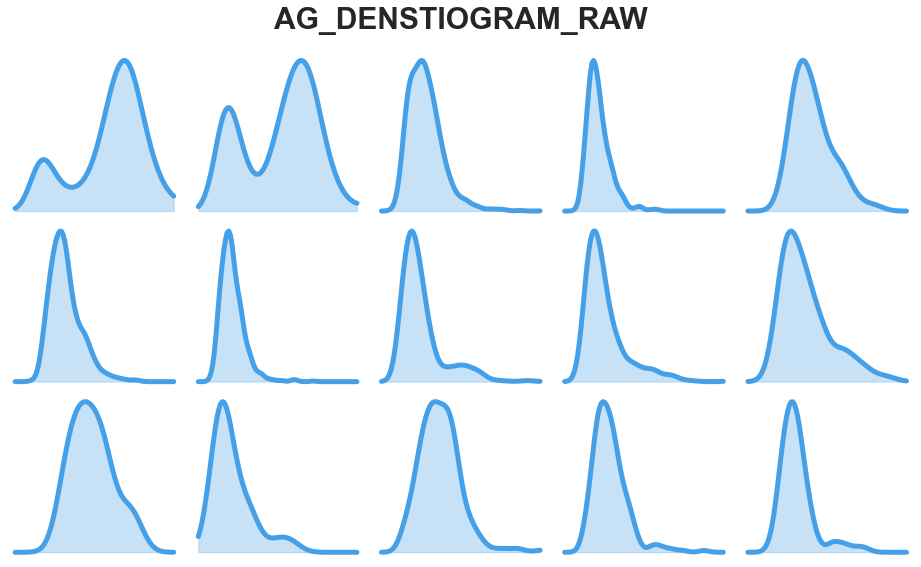

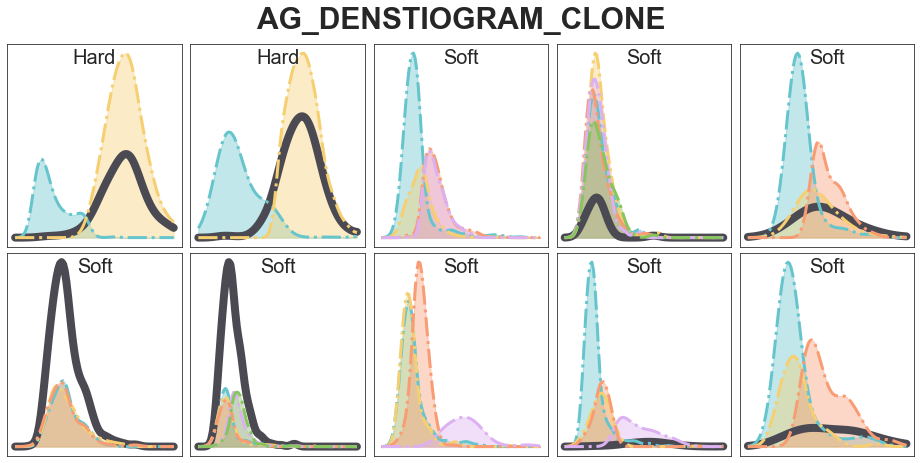

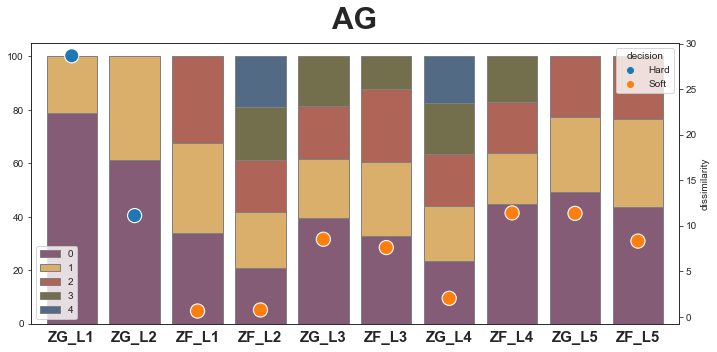

In [3]:
import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors

df_AG_count  = pd.DataFrame()
decision_dict = {}


# General_raw
fig_raw, ax_raw = plt.subplots(nrows = 3, ncols = 5, figsize = (14,8))
fig_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_raw.suptitle ( "AG_DENSTIOGRAM_RAW" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

# General_decomposition
fig_clone, ax_clone = plt.subplots(nrows = 2, ncols = 5, figsize = (14, 6.5))
fig_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_clone.suptitle ( "AG_DENSTIOGRAM_CLONE" , fontsize = 30, y = 0.98, fontweight = "semibold")




DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG"
for col_index, location in enumerate( ["L1", "L2", "L3", "L4", "L5"] ) :
    INPUT_TSV_LIST = sorted ( glob.glob ( DIR + "/*{}*".format(location) ) )

    glo_INPUT_TSV = DIR + "/glomerulosa_{}/0.input_containpos.txt".format(location)
    fasc_INPUT_TSV = DIR + "/fasciculata_{}/0.input_containpos.txt".format(location)
    reti_INPUT_TSV = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/3.woMosaic_ver2/PD28690/adrenal_gland_zona/reticularis_{}_input.txt".format(location)

    df_glo = pd.read_csv (glo_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_glo = calc_vaf (df_glo, "depthalt", location)
    df_fasc = pd.read_csv (fasc_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_fasc = calc_vaf (df_fasc, "depthalt", location)
    df_reti = pd.read_csv (reti_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_reti = calc_vaf (df_reti, "depthalt", location)

    df_glofasc = pd.merge ( df_glo,  df_fasc, left_on = "pos", right_on = "pos")
    
    drawfigure_raw ( ax_raw[0][col_index], df_glo, 0, col_index, "vaf", color = '#46A0E7' )
    drawfigure_raw ( ax_raw[1][col_index], df_fasc, 1, col_index, "vaf", color = '#46A0E7' )
    drawfigure_raw ( ax_raw[2][col_index], df_reti, 2, col_index, "vaf", color = '#46A0E7' )
    

    ####################################
    df_glo_membership = pd.read_csv ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/glomerulosa_{}/result/CLEMENT_decision.membership.txt".format(location), header = None, names = ["clone"])
    df_fasc_membership = pd.read_csv ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/fasciculata_{}/result/CLEMENT_decision.membership.txt".format(location), header = None, names = ["clone"])

    df_glo = pd.concat ( [df_glo, df_glo_membership], axis = 1)
    df_fasc = pd.concat ( [df_fasc, df_fasc_membership], axis = 1)


    #  Common 그리기
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )        # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[0][col_index], df_glofasc, 0, col_index, "vaf_x", weight)
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )      # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[1][col_index], df_glofasc, 1, col_index, "vaf_y", weight)

    # Clone 별로 그리기
    for clone_no in sorted ( set ( df_glo["clone"]) ) :
        weight = pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[0][col_index], df_glo [df_glo["clone"] == clone_no].reset_index(drop = True), 0, col_index, "vaf", clone_no, weight)
    for clone_no in sorted ( set ( df_fasc["clone"]) ) :
        weight = pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[1][col_index], df_fasc [df_fasc["clone"] == clone_no].reset_index(drop = True), 1, col_index, "vaf", clone_no, weight)

    # Hard, Soft 여부 적어놓기
    with open("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/glomerulosa_{}/result/CLEMENT_decision.evidence.txt".format (location), 'r') as file:
        decision_glo = "Hard" if "hard" in file.readline().rstrip() else "Soft"
    with open("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/fasciculata_{}/result/CLEMENT_decision.evidence.txt".format (location), 'r') as file:
        decision_fasc = "Hard" if "hard" in file.readline().rstrip() else "Soft"
    
    ax_clone[0][col_index].text (x = np.array (ax_clone[0][col_index].get_xlim()).mean(), y =  np.array (ax_clone[0][col_index].get_ylim())[1] * 0.9, ha = "center", s = "{}".format( decision_glo ), fontsize = 20, fontweight = "normal")
    ax_clone[1][col_index].text (x = np.array (ax_clone[1][col_index].get_xlim()).mean(), y =  np.array (ax_clone[1][col_index].get_ylim())[1] * 0.9, ha = "center", s = "{}".format( decision_fasc ), fontsize = 20, fontweight = "normal")

    decision_dict ["ZG_{}".format(location)] = decision_glo
    decision_dict ["ZF_{}".format(location)] = decision_fasc


    ##################### Stacked bar chart  (by mutation count) #####################
    temp = pd.read_csv ( "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/glomerulosa_{}".format (location) + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = ["ZG_{}".format(location)]
    df_AG_count = pd.concat ( [df_AG_count, temp], axis = 1).fillna(0).astype("int")
    temp = pd.read_csv ( "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/fasciculata_{}".format (location) + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = ["ZF_{}".format(location)]
    df_AG_count = pd.concat ( [df_AG_count, temp], axis = 1).fillna(0).astype("int")
    


colorlist = [i for i in Antique_10]
fig_AG_stackedbar, ax_AG_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
fig_AG_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.1, top = 0.88, left = 0.05, right = 0.95)
fig_AG_stackedbar.suptitle ( "AG" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs ["ORDER"], kwargs["ROTATION"] = "Hard-Soft", 0
normalize_df_AG, df_order_AG = stackedbar_tissue ( fig_AG_stackedbar, ax_AG_stackedbar, df_AG_count, decision_dict, colorlist, **kwargs)


##################### dissimilarity  (by mutation count) #####################
dissimilarity_df = pd.DataFrame ( normalize_df_AG.apply(std_without_zeros, axis=1)  )
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df = pd.merge ( dissimilarity_df, df_order_AG, left_index=True, right_index = True )    # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index
dissimilarity_df["TISSUE"] = "AG"
dissimilarity_df = dissimilarity_df.reset_index(drop = True)

ax_AG_stackedbar_twin = ax_AG_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, ax = ax_AG_stackedbar_twin )


fig_raw.savefig (OUTPUT_DIR + "/1-1.AG_densigoram_raw.jpg", dpi = 300)
fig_clone.savefig (OUTPUT_DIR + "/1-2.AG_densigoram_clone.jpg", dpi = 300)
fig_AG_stackedbar.savefig (OUTPUT_DIR + "/1-3.AG_stackedbar.jpg", dpi = 300)
fig_raw.show()
fig_clone.show()
fig_AG_stackedbar.show()


## Bronchus Epithelium

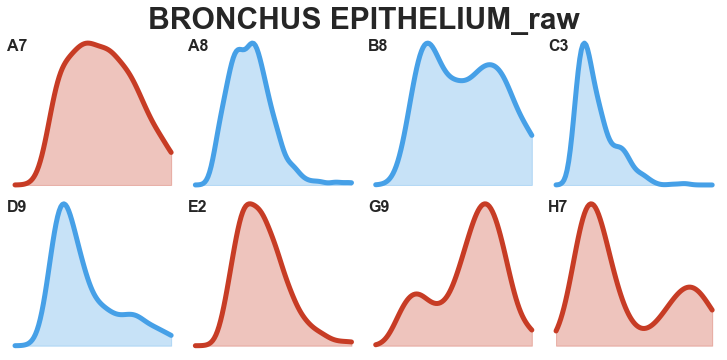

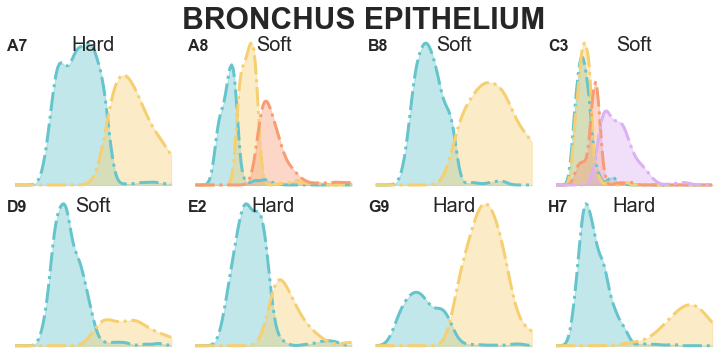

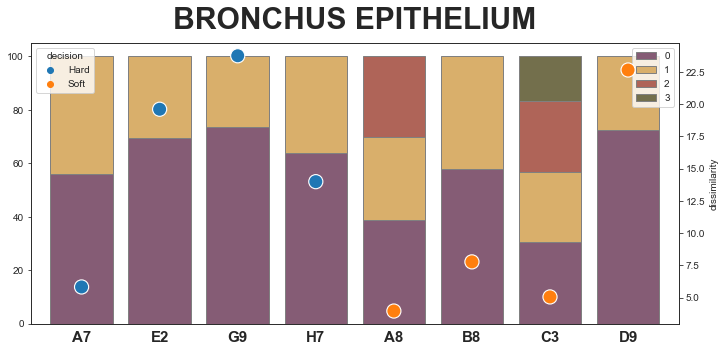

In [5]:
import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors


# General_clone
fig_bron_raw, ax_bron_raw = plt.subplots(nrows = 2, ncols = 4, figsize = (11,5))
fig_bron_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_bron_raw.suptitle ( "BRONCHUS EPITHELIUM_raw" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

# General_clone
fig_bron_clone, ax_bron_clone = plt.subplots(nrows = 2, ncols = 4, figsize = (11,5))
fig_bron_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_bron_clone.suptitle ( "BRONCHUS EPITHELIUM" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium"
INPUT_DIR_LIST = sorted ( glob.glob ( DIR + "/*".format(location) ) )


df_bron_count  = pd.DataFrame()
decision_dict = {}


for INPUT_DIR_ind, INPUT_DIR in enumerate (INPUT_DIR_LIST):
    ax_row, ax_col = int(INPUT_DIR_ind / 4), INPUT_DIR_ind % 4
    SAMPLENAME = INPUT_DIR.split("-")[-1]
    #print (SAMPLENAME, ax_row, ax_col)

    #################################################
    df_bron = pd.read_csv (INPUT_DIR + "/0.input_containpos.txt", sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_bron = calc_vaf (df_bron, "depthalt", SAMPLENAME)

    df_bron_membership = pd.read_csv ( INPUT_DIR + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

    df_bron = pd.concat ( [df_bron, df_bron_membership], axis = 1)


    with open( INPUT_DIR + "/CLEMENT_decision.evidence.txt".format (location), 'r') as file:
        decision_bron = "Hard" if "hard" in file.readline().rstrip() else "Soft"

    
    # Raw 그리기
    #drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#46A0E7' )   
    if decision_bron == "Hard":
        drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#C73C25' )
    elif decision_bron == "Soft":
        drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#46A0E7' )

    # Clone 별로 그리기
    for clone_no in sorted ( set ( df_bron["clone"]) ) :
        weight = pd.DataFrame (df_bron.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_bron.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_bron_clone[ax_row][ax_col], df_bron [df_bron["clone"] == clone_no].reset_index(drop = True), ax_row, ax_col, "vaf", clone_no, weight)

    # Hard, Soft 여부 적어놓기
    ax_bron_clone[ax_row][ax_col].text (x = np.array (ax_bron_clone[ax_row][ax_col].get_xlim()).mean(), 
                                                    y =  np.array (ax_bron_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "center", s = "{}".format( decision_bron ), fontsize = 20, fontweight = "normal")
    decision_dict [SAMPLENAME] = decision_bron

    # Sample 이름 적기
    ax_bron_clone[ax_row][ax_col].text (x = np.array (ax_bron_clone[ax_row][ax_col].get_xlim()).min(), 
                                                    y = np.array (ax_bron_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "left", s = "{}".format( SAMPLENAME ), fontsize = 16, fontweight = "semibold")
    
    ax_bron_raw[ax_row][ax_col].text (x = np.array (ax_bron_raw[ax_row][ax_col].get_xlim()).min(), 
                                                    y = np.array (ax_bron_raw[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "left", s = "{}".format( SAMPLENAME ), fontsize = 16, fontweight = "semibold")
    

    ##################### Stacked bar chart  (by mutation count) #####################
    temp = pd.read_csv ( INPUT_DIR + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = [SAMPLENAME]
    df_bron_count = pd.concat ( [df_bron_count, temp], axis = 1).fillna(0).astype("int")



colorlist = [i for i in Antique_10]
fig_bron_stackedbar, ax_bron_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
fig_bron_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.1, top = 0.88, left = 0.05, right = 0.95)
fig_bron_stackedbar.suptitle ( "BRONCHUS EPITHELIUM" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs ["ORDER"], kwargs["ROTATION"] = "Hard-Soft", 0
normalize_df_bron, df_order_bron = stackedbar_tissue ( fig_bron_stackedbar, ax_bron_stackedbar, df_bron_count, decision_dict, colorlist, **kwargs)



##################### dissimilarity  (by mutation count) #####################
dissimilarity_df = pd.DataFrame ( normalize_df_bron.apply(std_without_zeros, axis=1)  )
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df = pd.merge ( dissimilarity_df, df_order_bron, left_index=True, right_index = True )    # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index    # SAMPLENAME column 생성
dissimilarity_df["TISSUE"] = "Bronchus_Epithelium"            # TISSUE column 생성
dissimilarity_df = dissimilarity_df.reset_index(drop = True)

ax_bron_stackedbar_twin = ax_bron_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, ax = ax_bron_stackedbar_twin )

fig_bron_raw.savefig (OUTPUT_DIR + "/2-1.Bronchus_densigoram_raw.jpg", dpi = 300)
fig_bron_clone.savefig (OUTPUT_DIR + "/2-2.Bronchus_densigoram_clone.jpg", dpi = 300)
fig_bron_stackedbar.savefig (OUTPUT_DIR + "/2-3.Bronchus_stackedbar.jpg", dpi = 300)

## TOTAL

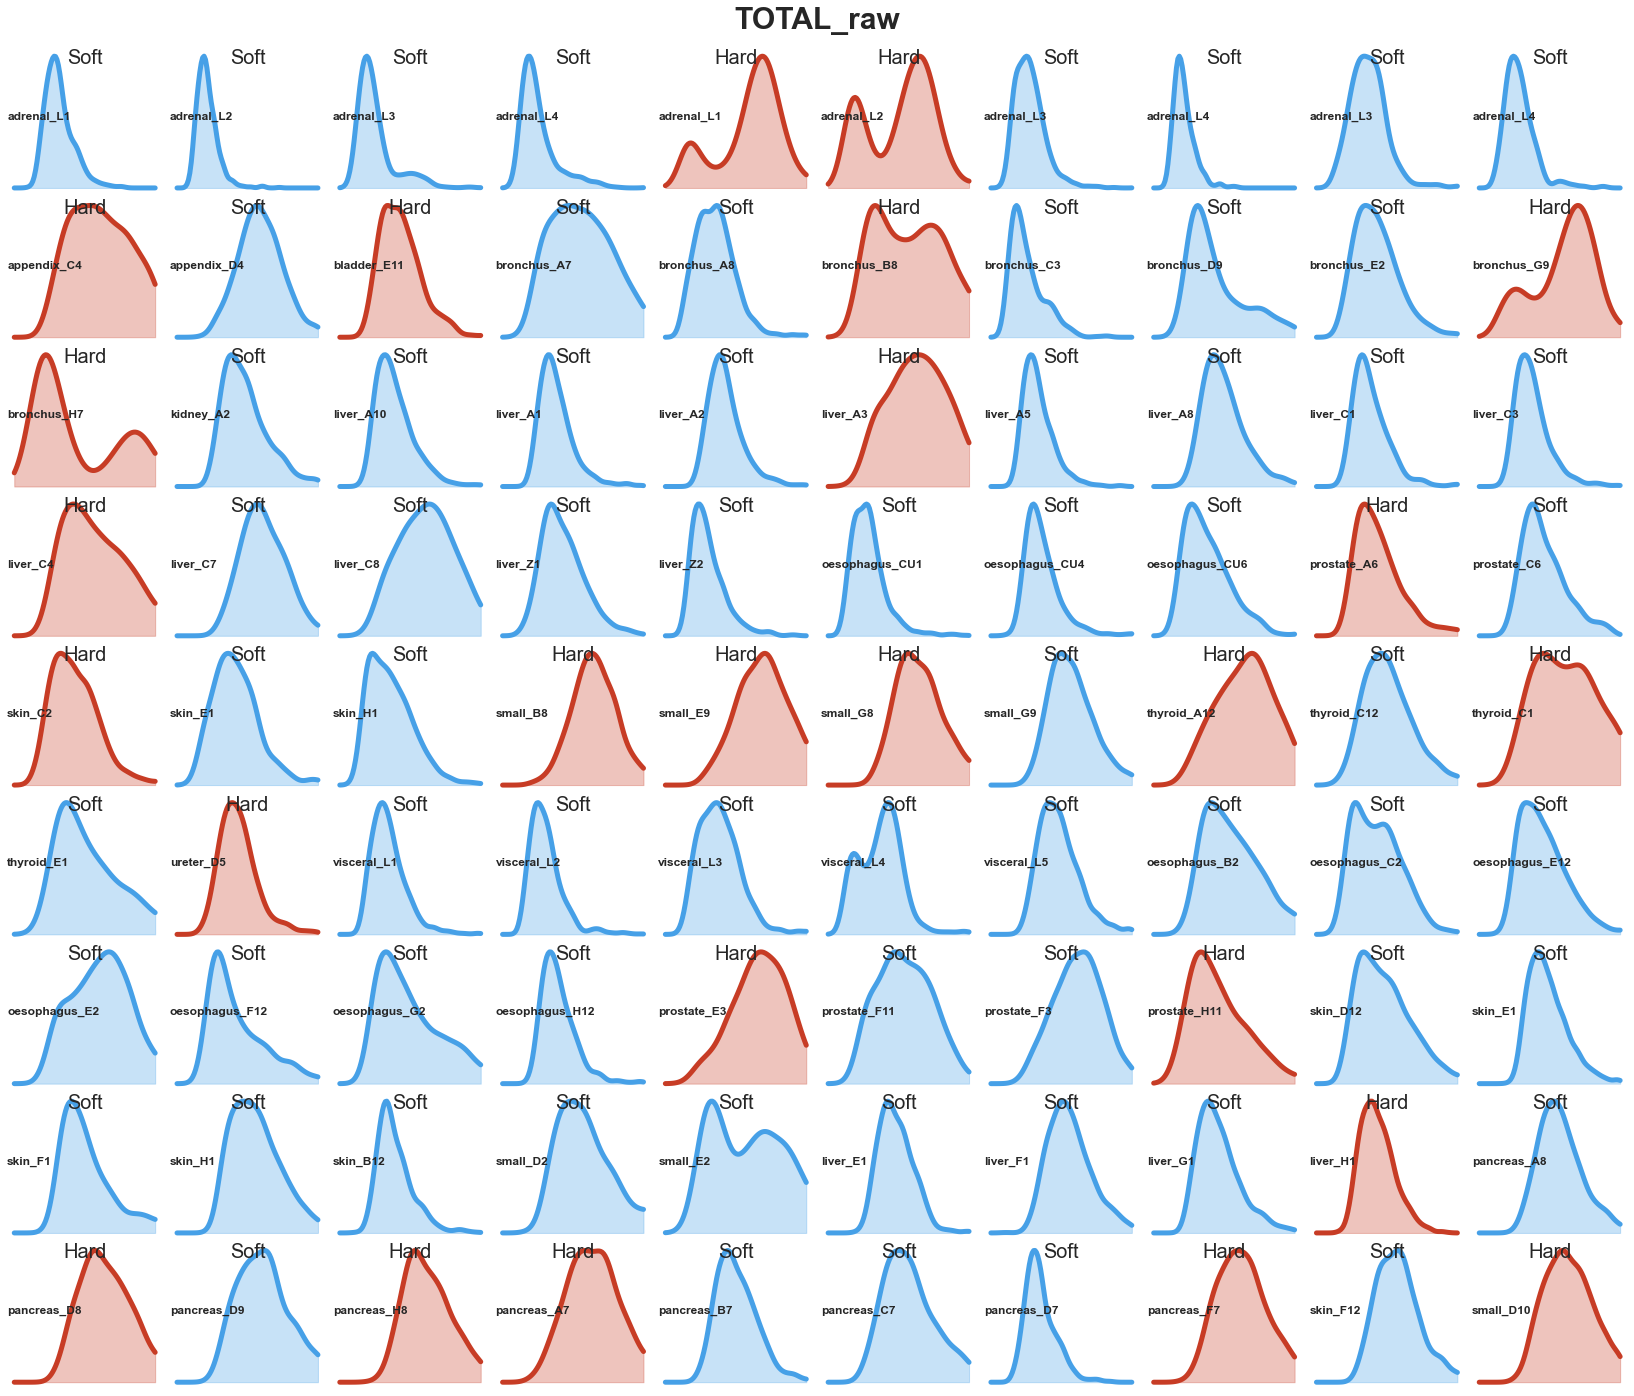

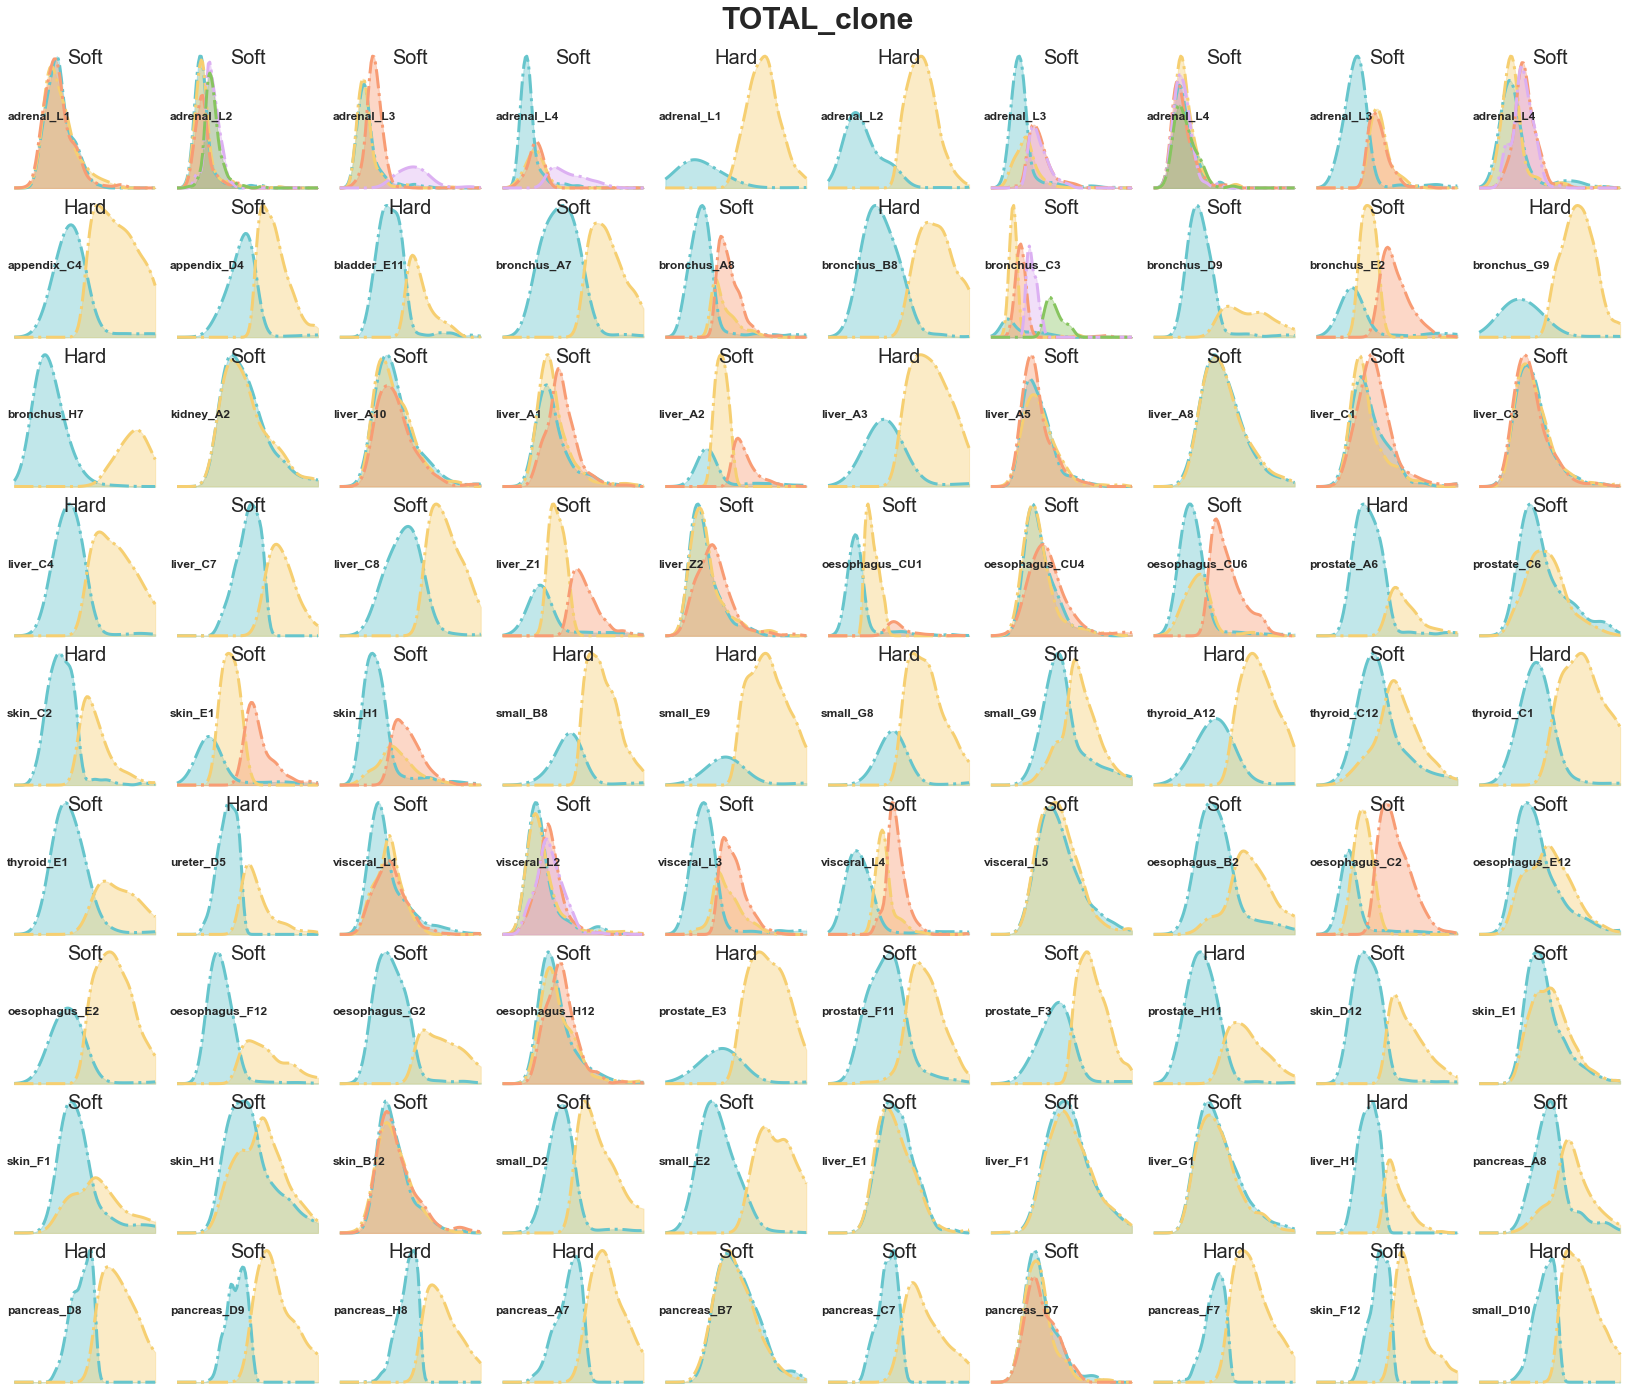

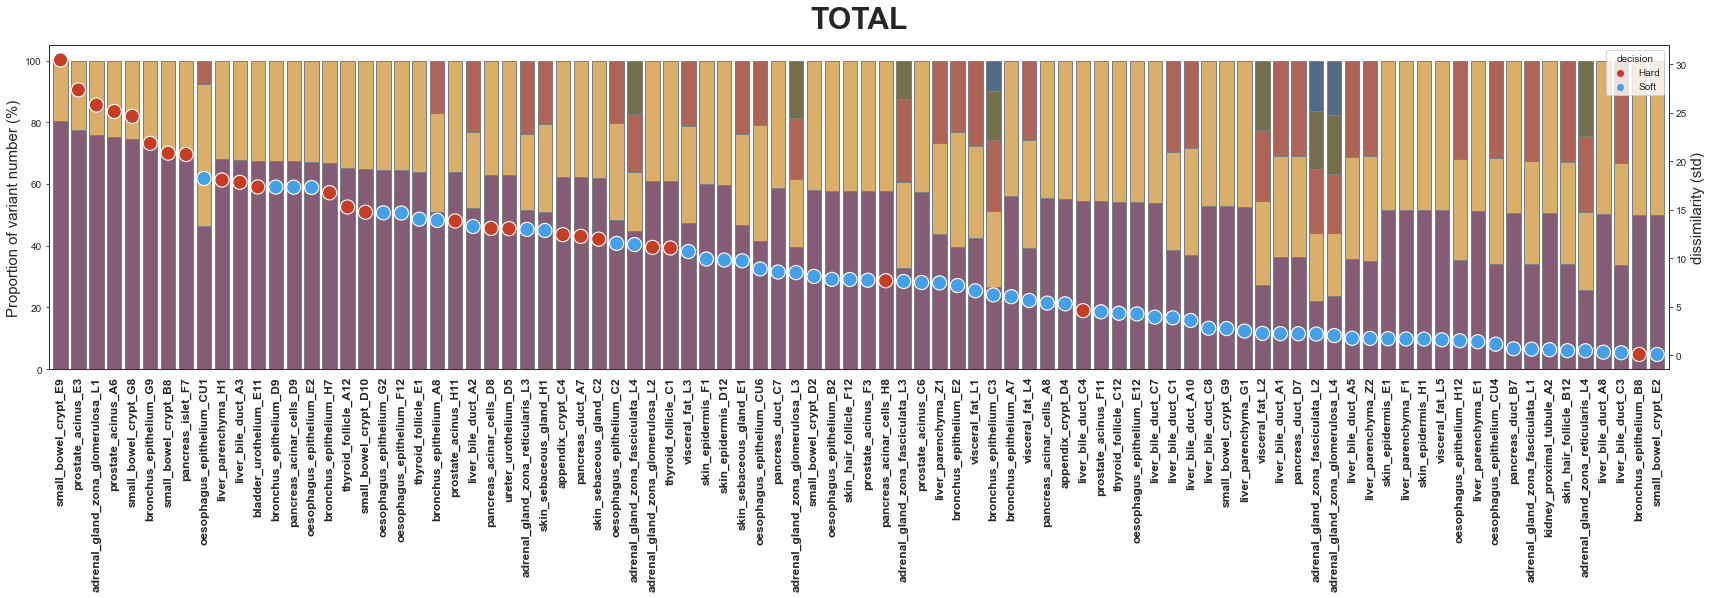

In [173]:
df_total_count  = pd.DataFrame()
decision_dict = {}

import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors


# General
fig_total_raw, ax_total_raw = plt.subplots(nrows = 9, ncols = 10, figsize = (25, 20))
fig_total_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
fig_total_raw.suptitle ( "TOTAL_raw" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

fig_total_clone, ax_total_clone = plt.subplots(nrows = 9, ncols = 10, figsize = (25, 20))
fig_total_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
fig_total_clone.suptitle ( "TOTAL_clone" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )



DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/2.woMosaic_ver1"        # AG : 3.woMosaic_ver2
DONOR_LIST = [i.split("/")[-1] for i in sorted(glob.glob(DIR + "/*")) ]
n = 0
n_monoclonal = 0
n_hard = 0

for DONOR in DONOR_LIST:               # PD42566
    TISSUE_LIST = sorted( glob.glob (DIR + "/" + DONOR + "/*") ) 
    TISSUE_LIST = [i.split("/")[-1] for i in TISSUE_LIST]

    for TISSUE in TISSUE_LIST:               # colon_crypt, pancreas_islet
    #for TISSUE in [ "totalchus_epithelium", "liver_parenchyma" ]:

        SAMPLE_LIST = sorted ( glob.glob (DIR + "/" + DONOR + "/" + TISSUE + "/*") ) 
        SAMPLE_LIST = [i.split("/")[-1].split(".")[0] for i in SAMPLE_LIST]

        for SAMPLE in SAMPLE_LIST:       # PD42566b_lo00_A7.txt
            SAMPLENAME = SAMPLE.split("_")[0]
            INPUT_TSV = DIR + "/" + DONOR + "/" + TISSUE + "/" + SAMPLE + ".txt"

            COMBINED_OUTPUT_DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME

            if os.path.exists( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ) == False:   # 없다면 (CLEMENT error) 그냥 넘어가자
                continue
            result_df = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt", sep = "\t", header = None, index_col = 0)
            if result_df.loc["NUM_CHILD"][1] == "1":    # monoclonal은 집에 가라
                n_monoclonal += 1
                continue


            #################################################
            ax_row, ax_col = int(n / 10), n % 10

            df_total = pd.read_csv ( COMBINED_OUTPUT_DIR + "/0.input_containpos.txt", sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
            df_total = calc_vaf (df_total, "depthalt", SAMPLENAME)

            df_total_membership = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

            df_total = pd.concat ( [df_total, df_total_membership], axis = 1)

            

            with open( COMBINED_OUTPUT_DIR  + "/CLEMENT_decision.evidence.txt".format (location), 'r') as file:
                decision = "Hard" if "hard" in file.readline().rstrip() else "Soft"
                if decision == "Hard":
                    n_hard +=1
            decision_dict [TISSUE + "_" + SAMPLENAME] = decision


            # Raw 그리기
            if decision == "Hard":
                drawfigure_raw ( ax_total_raw[ax_row][ax_col], df_total, ax_row, ax_col, "vaf", color = '#C73C25' )
            elif decision == "Soft":
                drawfigure_raw ( ax_total_raw[ax_row][ax_col], df_total, ax_row, ax_col, "vaf", color = '#46A0E7' )

            # Clone 별로 그리기
            for clone_no in sorted ( set ( df_total["clone"]) ) :
                weight = pd.DataFrame (df_total.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_total.groupby(["clone"]).count()).iloc[:, 0] )
                drawfigure_clone ( ax_total_clone[ax_row][ax_col], df_total [df_total["clone"] == clone_no].reset_index(drop = True), ax_row, ax_col, "vaf", clone_no, weight)


            # Hard, Soft 여부 적어놓기
            ax_total_raw[ax_row][ax_col].text (x = np.array (ax_total_raw[ax_row][ax_col].get_xlim()).mean(), 
                                                                    y =  np.array (ax_total_raw[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                                    ha = "center", s = "{}".format( decision ), fontsize = 20, fontweight = "normal")
            ax_total_clone[ax_row][ax_col].text (x = np.array (ax_total_clone[ax_row][ax_col].get_xlim()).mean(), 
                                                                    y =  np.array (ax_total_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                                    ha = "center", s = "{}".format( decision ), fontsize = 20, fontweight = "normal")

            # Sample 이름 적기
            ax_total_raw[ax_row][ax_col].text (x = np.array (ax_total_raw[ax_row][ax_col].get_xlim()).min(), 
                                                                        y = np.array (ax_total_raw[ax_row][ax_col].get_ylim())[1] * 0.5, 
                                                                        ha = "left", s = "{}_{}".format( TISSUE.split("_")[0], SAMPLENAME ), fontsize = 12, fontweight = "semibold")
            ax_total_clone[ax_row][ax_col].text (x = np.array (ax_total_clone[ax_row][ax_col].get_xlim()).min(), 
                                                                        y = np.array (ax_total_clone[ax_row][ax_col].get_ylim())[1] * 0.5, 
                                                                        ha = "left", s = "{}_{}".format( TISSUE.split("_")[0], SAMPLENAME ), fontsize = 12, fontweight = "semibold")


            ##################### Stacked bar chart  (by mutation count) #####################
            temp = pd.read_csv ( COMBINED_OUTPUT_DIR  + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
            temp.columns = [TISSUE + "_" + SAMPLENAME]
            df_total_count = pd.concat ( [df_total_count, temp], axis = 1).fillna(0)


            #print (DONOR, TISSUE, SAMPLE, result_df.loc["NUM_CHILD"][1], decision, sep = "\t")
            n += 1


from collections import OrderedDict 
df_order = pd.DataFrame.from_dict ( OrderedDict (decision_dict), orient = "index" )
df_order.columns = ["decision"]


##################### dissimilarity  (by mutation count) #####################
normalized_df_total = df_total_count.div(df_total_count.sum(axis=0), axis=1).T * 100
normalized_df_total = normalized_df_total.apply(lambda row: pd.Series(sorted(row, reverse = True)), axis=1)

dissimilarity_df = pd.DataFrame ( normalized_df_total.apply(std_without_zeros, axis=1)  )  # dissimilarity score 계산
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df = pd.concat ( [dissimilarity_df, df_order], axis = 1)          # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index                       # SAMPLENAME column 생성
dissimilarity_df["TISSUE"] = dissimilarity_df["SAMPLENAME"].str.rsplit("_", n = 1).str[0]  # TISSUE column 생성
dissimilarity_df = dissimilarity_df.reset_index(drop = True)
dissimilarity_df = dissimilarity_df.sort_values (by = "dissimilarity", ascending = False, axis = 0)  # score에 따라 sort

normalized_df_total = normalized_df_total.loc [ list( dissimilarity_df["SAMPLENAME"]), : ]  # score에 따라 sort




colorlist = [i for i in Antique_10]
fig_total_stackedbar, ax_total_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (25,9))
fig_total_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.42, top = 0.92, left = 0.05, right = 0.95)
fig_total_stackedbar.suptitle ( "TOTAL" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs["ROTATION"] = 90
stackedbar_by_score (  fig_total_stackedbar, ax_total_stackedbar, normalized_df_total, colorlist, **kwargs)

ax_total_stackedbar_twin = ax_total_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, palette = {"Hard" : '#C73C25', "Soft" : '#46A0E7' }, ax = ax_total_stackedbar_twin )
ax_total_stackedbar_twin.set_ylabel ("dissimilarity (std)", fontsize = 15, fontweight = "normal")



fig_total_raw.savefig (OUTPUT_DIR + "/3-1.Total_densigoram_raw.jpg", dpi = 300)
fig_total_clone.savefig (OUTPUT_DIR + "/3-2.Total_densigoram_clone.jpg", dpi = 300)
fig_total_stackedbar.savefig (OUTPUT_DIR + "/3-3.Total_stackedbar.jpg", dpi = 300)

In [165]:
dissimilarity_df

,dissimilarity,decision,SAMPLENAME,TISSUE
44,30.453258,Hard,small_bowel_crypt_E9,small_bowel_crypt
64,27.360140,Hard,prostate_acinus_E3,prostate_acinus
4,25.802662,Hard,adrenal_gland_zona_glomerulosa_L1,adrenal_gland_zona_glomerulosa
38,25.137363,Hard,prostate_acinus_A6,prostate_acinus
45,24.637681,Hard,small_bowel_crypt_G8,small_bowel_crypt
...,...,...,...,...
9,0.463823,Soft,adrenal_gland_zona_reticularis_L4,adrenal_gland_zona_reticularis
27,0.316456,Soft,liver_bile_duct_A8,liver_bile_duct
29,0.267085,Soft,liver_bile_duct_C3,liver_bile_duct
15,0.086655,Hard,bronchus_epithelium_B8,bronchus_epithelium


In [166]:
normalized_df_total

,0,1,2,3,4
small_bowel_crypt_E9,80.453258,19.546742,0.000000,0.000000,0.0
prostate_acinus_E3,77.360140,22.639860,0.000000,0.000000,0.0
adrenal_gland_zona_glomerulosa_L1,75.802662,24.197338,0.000000,0.000000,0.0
prostate_acinus_A6,75.137363,24.862637,0.000000,0.000000,0.0
small_bowel_crypt_G8,74.637681,25.362319,0.000000,0.000000,0.0
...,...,...,...,...,...
adrenal_gland_zona_reticularis_L4,25.708502,25.101215,24.696356,24.493927,0.0
liver_bile_duct_A8,50.316456,49.683544,0.000000,0.000000,0.0
liver_bile_duct_C3,33.711048,33.144476,33.144476,0.000000,0.0
bronchus_epithelium_B8,50.086655,49.913345,0.000000,0.000000,0.0


In [174]:
print ("n(monoclonal)\t{}\nn(hard)\t{}\nn(soft)\t{}\nn(total)\t{}".format (n_monoclonal, n_hard, n - n_hard, n))

n(monoclonal)	109
n(hard)	25
n(soft)	65
n(total)	90
